In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
!unzip project2026.zip
!ls -l

--2026-01-19 07:16:38--  https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138578548 (132M) [application/zip]
Saving to: ‘project2026.zip’

project2026.zip     100%[===================>] 132.16M  58.2MB/s    in 2.3s    

2026-01-19 07:16:40 (58.2 MB/s) - ‘project2026.zip’ saved [138578548/138578548]

Archive:  project2026.zip
  inflating: games.data              
  inflating: golois.cpython-312-x86_64-linux-gnu.so  
total 665408
-rw-r--r-- 1 root root 542497580 Oct  7  2022 games.data
-rwxr-xr-x 1 root root    284672 Oct  1 15:09 golois.cpython-312-x86_64-linux-gnu.so
-rw-r--r-- 1 root root 138578548 Oct  1 20:02 project2026.zip
drwxr-xr-x 1 root root      4096 Dec  9 14:42 sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc
import matplotlib.pyplot as plt
import pandas as pd
import golois

planes = 31
moves = 361
N = 50000
epochs = 1000
batch = 128
filters = 32

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

In [ ]:
policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)
policy = policy.astype ('float32')

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("Tensorflow version", tf.__version__)
print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)

Tensorflow version 2.19.0
getValidation


In [ ]:
# Define checkpoint directory (persistent on Drive)
import os
import json
checkpoint_dir = "/content/drive/MyDrive/GO_DL_mobileNet_resNet/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "model_last.keras")
progress_file = os.path.join(checkpoint_dir, "progress.json")
metrics_path = "/content/drive/MyDrive/GO_DL_mobileNet_resNet/training_metrics.csv"


progress_file = "/content/drive/MyDrive/GO_DL_mobileNet_resNet/checkpoints/progress.json"
if os.path.exists(progress_file):
    !cat {progress_file}
else:
    print(f"File not found: {progress_file}")

# Metrics saving
# Initialize metrics storage
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(columns=[
        "epoch",
        "train_policy_loss", "train_value_loss",
        "train_policy_acc", "train_value_mae",
        "val_policy_loss", "val_value_loss",
        "val_policy_acc", "val_value_mae"
    ])


{"last_epoch": 1729}

In [ ]:
def batchNorm_residual_block(x, filters):
    shortcut = x

    # First conv + BN + ReLU
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv + BN (no ReLU yet)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    x = layers.Add()([x, shortcut])

    # Final ReLU after addition
    x = layers.Activation('relu')(x)

    return x

def inverted_residual_block(x, expansion_factor, out_channels, stride=1, use_residual=True):
    """
    MobileNetV2-style inverted residual block
    - Expands channels with 1x1 conv
    - Depthwise conv in expanded space
    - Projects back down with 1x1 conv
    """
    in_channels = x.shape[-1]
    expanded_channels = in_channels * expansion_factor

    # Expansion phase
    if expansion_factor != 1:
        expand = layers.Conv2D(expanded_channels, 1, padding='same', use_bias=False)(x)
        expand = layers.BatchNormalization()(expand)
        expand = layers.Activation('relu')(expand)
    else:
        expand = x

    # Depthwise convolution
    depthwise = layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(expand)
    depthwise = layers.BatchNormalization()(depthwise)
    depthwise = layers.Activation('relu')(depthwise)

    # Projection phase (linear)
    project = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(depthwise)
    project = layers.BatchNormalization()(project)

    # Residual connection
    if use_residual and stride == 1 and in_channels == out_channels:
        return layers.Add()([x, project])
    return project

def efficient_attention_block(x, channels):
    """
    Lightweight spatial attention mechanism
    Helps the network focus on important board regions
    """
    # Channel attention (squeeze-excitation style)
    squeeze = layers.GlobalAveragePooling2D()(x)
    excite = layers.Dense(channels // 4, activation='relu')(squeeze)
    excite = layers.Dense(channels, activation='sigmoid')(excite)
    excite = layers.Reshape((1, 1, channels))(excite)

    return layers.Multiply()([x, excite])

def build_mobilenet_go_model_V0(filters=24):
    """
    MobileNet-inspired architecture for Go
    Optimized for ~100K parameters

    Key innovations:
    1. Inverted residual blocks (MobileNetV2 style)
    2. Efficient attention mechanism
    3. Shared feature extraction with specialized heads
    4. Optimized channel dimensions
    """

    input_layer = keras.Input(shape=(19, 19, planes), name='board')

    # Initial convolution - establish base features
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Inverted residual blocks with progressive channel expansion
    # Stage 1: t=2, k=3, c=24, n=2
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)

    # Stage 2: t=3, k=3, c=32, n=2 (increase channels slightly)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)

    # Attention mechanism to focus on critical board positions
    x = efficient_attention_block(x, filters + 8)

    # Stage 3: t=3, k=3, c=32, n=2 (maintain channels)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)

    # residual blocks
    for i in range(2):
      x = batchNorm_residual_block(x, filters+8)

    # Final feature refinement
    x = layers.Conv2D(filters + 16, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ========== POLICY HEAD ==========
    # Lightweight policy head using depthwise separable convolutions
    policy = layers.SeparableConv2D(16, 3, padding='same', use_bias=False)(x)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(2, 1, padding='same', use_bias=False)(policy)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(1, 1, padding='same', use_bias=False,
                          kernel_regularizer=regularizers.l2(0.0001))(policy)
    policy = layers.Flatten()(policy)
    policy = layers.Activation('softmax', name='policy')(policy)

    # ========== VALUE HEAD ==========
    # Efficient value head with global pooling
    value = layers.Conv2D(8, 1, padding='same', use_bias=False)(x)
    value = layers.BatchNormalization()(value)
    value = layers.Activation('relu')(value)

    # Global average pooling reduces spatial dimensions efficiently
    value = layers.GlobalAveragePooling2D()(value)

    value = layers.Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(value)
    value = layers.Dropout(0.3)(value)
    value = layers.Dense(1, activation='sigmoid', name='value',
                        kernel_regularizer=regularizers.l2(0.0001))(value)

    model = keras.Model(inputs=input_layer, outputs=[policy, value])

    return model

def build_mobilenet_go_model_V2(filters=24):
    """
    Strategic placement of residual blocks in MobileNet architecture
    """

    input_layer = keras.Input(shape=(19, 19, planes), name='board')

    # Initial convolution
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Early stage: MobileNet blocks for efficiency
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)

    # Middle stage: Mix of both block types
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = batchNorm_residual_block(x, filters + 8)  # Residual for feature refinement

    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = batchNorm_residual_block(x, filters + 8)  # Residual for feature refinement

    # Attention mechanism
    x = efficient_attention_block(x, filters + 8)

    # Late stage: More residual blocks for final refinement
    x = batchNorm_residual_block(x, filters + 8)
    #x = batchNorm_residual_block(x, filters + 8)

    # Final feature refinement
    x = layers.Conv2D(filters + 16, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ========== POLICY HEAD ==========
    # Lightweight policy head using depthwise separable convolutions
    policy = layers.SeparableConv2D(16, 3, padding='same', use_bias=False)(x)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(2, 1, padding='same', use_bias=False)(policy)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(1, 1, padding='same', use_bias=False,
                          kernel_regularizer=regularizers.l2(0.0001))(policy)
    policy = layers.Flatten()(policy)
    policy = layers.Activation('softmax', name='policy')(policy)

    # ========== VALUE HEAD ==========
    # Efficient value head with global pooling
    value = layers.Conv2D(8, 1, padding='same', use_bias=False)(x)
    value = layers.BatchNormalization()(value)
    value = layers.Activation('relu')(value)

    # Global average pooling reduces spatial dimensions efficiently
    value = layers.GlobalAveragePooling2D()(value)

    value = layers.Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(value)
    value = layers.Dropout(0.3)(value)
    value = layers.Dense(1, activation='sigmoid', name='value',
                        kernel_regularizer=regularizers.l2(0.0001))(value)

    model = keras.Model(inputs=input_layer, outputs=[policy, value])

    return model

# Build and display model
model = build_mobilenet_go_model_V0(filters=24)
model.summary()


# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
    loss_weights={'policy': 1.0, 'value': 1.0},
    metrics={'policy': 'categorical_accuracy', 'value': 'mae'}
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ board (InputLayer)  │ (None, 19, 19,    │          0 │ -                 │
│                     │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 19, 19,    │      6,696 │ board[0][0]       │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 19, 19,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 19,    │      1,152 │ activation[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        192 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 19, 19,    │        432 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        192 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 19,    │      1,152 │ activation_2[0][… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         96 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 19,    │          0 │ activation[0][0], │
│                     │ 24)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 19,    │      1,152 │ add[0][0]         │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        192 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 19, 19,    │        432 │ activation_3[0][

 Total params: 83,467 (326.04 KB)

 Trainable params: 80,855 (315.84 KB)

 Non-trainable params: 2,612 (10.20 KB)

In [ ]:

# resume if previous checkpoint exists
start_epoch = 0
if os.path.exists(checkpoint_path) and os.path.exists(progress_file):
    print("Loading model from checkpoint...")
    model = keras.models.load_model(checkpoint_path)
    with open(progress_file, "r") as f:
        start_epoch = json.load(f)["last_epoch"]
    print(f"Resuming from epoch {start_epoch + 1}")
else:
    print("Starting training from scratch")

# training
for i in range(start_epoch + 1, start_epoch + epochs + 1):
    print('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    # data augmentation
    # todo
    history = model.fit(input_data,
                        [policy,value],
                        epochs=1, batch_size=batch)
    # save JSON progress every epoch (lightweight)
    with open(progress_file, "w") as f:
        json.dump({"last_epoch": i}, f)

    # Get training metrics
    train_metrics = history.history
    train_policy_loss = train_metrics['policy_loss'][-1]
    train_value_loss = train_metrics['value_loss'][-1]
    train_policy_acc = train_metrics['policy_categorical_accuracy'][-1]
    train_value_mae = train_metrics['value_mae'][-1]

    if (i % 5 == 0):
        gc.collect ()
    # Save progress every 20 epochs
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)

        val_policy_loss = val[1]
        val_value_loss = val[2]
        val_policy_acc = val[3]
        val_value_mae = val[4]
        print("val =", val)
        # save model + progress
        model.save(checkpoint_path)
        print(f"Saved checkpoint at epoch {i}")
        # Append metrics to dataframe
        metrics_df.loc[len(metrics_df)] = [
            i,
            train_policy_loss, train_value_loss,
            train_policy_acc, train_value_mae,
            val_policy_loss, val_value_loss,
            val_policy_acc, val_value_mae
        ]

        # Save metrics file
        metrics_df.to_csv(metrics_path, index=False)

Loading model from checkpoint...
Resuming from epoch 1710
epoch 1710
391/391 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - loss: 2.0786 - policy_categorical_accuracy: 0.4572 - policy_loss: 1.9586 - value_loss: 0.1198 - value_mae: 0.2918
epoch 1711
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 2.0833 - policy_categorical_accuracy: 0.4545 - policy_loss: 1.9623 - value_loss: 0.1208 - value_mae: 0.2937
epoch 1712
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 2.0821 - policy_categorical_accuracy: 0.4530 - policy_loss: 1.9614 - value_loss: 0.1206 - value_mae: 0.2931
epoch 1713
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 2.0852 - policy_categorical_accuracy: 0.4526 - policy_loss: 1.9641 - value_loss: 0.1208 - value_mae: 0.2939
epoch 1714
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 2.0750 - policy_categorical_accuracy: 0.4568 - policy_loss: 1.9539 - value_loss: 0.1209 - value_mae: 0.2937
epoch 1715
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 2.0753 - policy_categorical_ac

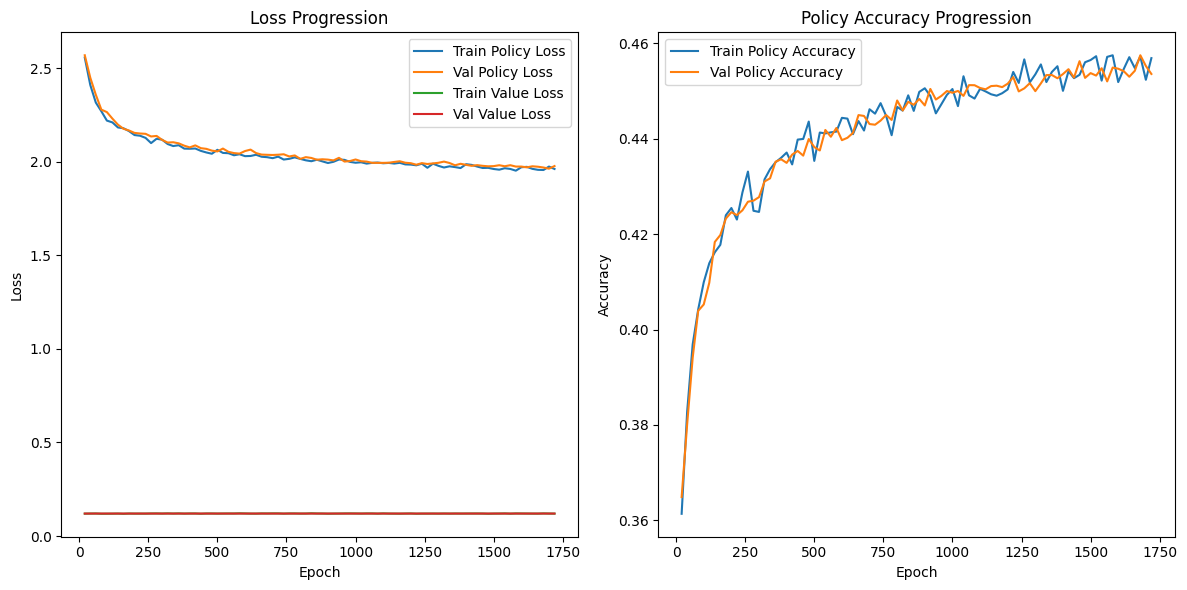

In [ ]:
# Reload metrics
metrics_df = pd.read_csv(metrics_path)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(metrics_df["epoch"], metrics_df["train_policy_loss"], label="Train Policy Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_policy_loss"], label="Val Policy Loss")
plt.plot(metrics_df["epoch"], metrics_df["train_value_loss"], label="Train Value Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_value_loss"], label="Val Value Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Progression")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics_df["epoch"], metrics_df["train_policy_acc"], label="Train Policy Accuracy")
plt.plot(metrics_df["epoch"], metrics_df["val_policy_acc"], label="Val Policy Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Policy Accuracy Progression")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
metrics_df

,epoch,train_policy_loss,train_value_loss,train_policy_acc,train_value_mae,val_policy_loss,val_value_loss,val_policy_acc,val_value_mae
0,20.0,2.556340,0.119670,0.36138,0.291672,2.568637,0.120233,0.36488,0.292521
1,40.0,2.409557,0.120232,0.38284,0.292622,2.448634,0.120233,0.38018,0.292522
2,60.0,2.315750,0.120546,0.39690,0.293275,2.357647,0.120237,0.39412,0.292517
3,80.0,2.269564,0.119147,0.40424,0.290877,2.278157,0.120301,0.40394,0.292611
4,100.0,2.219588,0.119335,0.40992,0.291042,2.264976,0.120235,0.40526,0.292508
...,...,...,...,...,...,...,...,...,...
81,1640.0,1.961792,0.119947,0.45710,0.292049,1.975444,0.120234,0.45300,0.292514
82,1660.0,1.956628,0.119810,0.45482,0.291714,1.973191,0.120246,0.45424,0.292541
83,1680.0,1.955654,0.120967,0.45724,0.293957,1.968909,0.120268,0.45750,0.292576
84,1700.0,1.973990,0.120257,0.45236,0.292685,1.962810,0.120242,0.45526,0.292531


In [ ]:
metrics_df.head(60)

,epoch,train_policy_loss,train_value_loss,train_policy_acc,train_value_mae,val_policy_loss,val_value_loss,val_policy_acc,val_value_mae
0,20.0,2.556340,0.119670,0.36138,0.291672,2.568637,0.120233,0.36488,0.292521
1,40.0,2.409557,0.120232,0.38284,0.292622,2.448634,0.120233,0.38018,0.292522
2,60.0,2.315750,0.120546,0.39690,0.293275,2.357647,0.120237,0.39412,0.292517
3,80.0,2.269564,0.119147,0.40424,0.290877,2.278157,0.120301,0.40394,0.292611
4,100.0,2.219588,0.119335,0.40992,0.291042,2.264976,0.120235,0.40526,0.292508
5,120.0,2.209926,0.119657,0.41390,0.292059,2.230227,0.120236,0.40980,0.292515
6,140.0,2.182980,0.120110,0.41620,0.292427,2.197857,0.120235,0.41836,0.292507
7,160.0,2.178668,0.118982,0.41776,0.290494,2.176049,0.120239,0.41982,0.292523
8,180.0,2.163538,0.120306,0.42396,0.293132,2.166757,0.120233,0.42326,0.292516
9,200.0,2.142334,0.119878,0.42548,0.291884,2.153891,0.120236,0.42460,0.292513


In [ ]:
metrics_df.tail(60)

,epoch,train_policy_loss,train_value_loss,train_policy_acc,train_value_mae,val_policy_loss,val_value_loss,val_policy_acc,val_value_mae
26,540.0,2.045408,0.120578,0.44112,0.293241,2.052701,0.120237,0.44184,0.292540
27,560.0,2.034378,0.120494,0.44134,0.293330,2.046005,0.120241,0.44042,0.292531
28,580.0,2.039773,0.121460,0.44150,0.294642,2.043128,0.120233,0.44226,0.292520
29,600.0,2.029632,0.120744,0.44438,0.293311,2.056905,0.120238,0.43970,0.292519
30,620.0,2.030559,0.119896,0.44422,0.291845,2.064580,0.120234,0.44020,0.292509
31,640.0,2.037076,0.119752,0.44096,0.291902,2.046049,0.120234,0.44122,0.292512
32,660.0,2.026473,0.120870,0.44370,0.293872,2.037936,0.120249,0.44496,0.292563
33,680.0,2.024135,0.120634,0.44172,0.293349,2.036798,0.120233,0.44478,0.292517
34,700.0,2.018810,0.121092,0.44618,0.294052,2.035874,0.120236,0.44308,0.292538
35,720.0,2.027101,0.121008,0.44526,0.294087,2.037297,0.120233,0.44294,0.292515


In [ ]:
filtered_df = metrics_df[(metrics_df['epoch'] >= 920.0) & (metrics_df['epoch'] <= 1720.0)]
max_val_policy_acc = filtered_df['val_policy_acc'].max()
min_val_policy_acc = filtered_df['val_policy_acc'].min()

print(f"Maximum val_policy_acc from epoch 920.0 to 1720.0: {max_val_policy_acc}")
print(f"Minimum val_policy_acc from epoch 920.0 to 1720.0: {min_val_policy_acc}")

Maximum val_policy_acc from epoch 920.0 to 1720.0: 0.457500010728836
Minimum val_policy_acc from epoch 920.0 to 1720.0: 0.4482200145721435


In [ ]:
model = keras.models.load_model(os.path.join(checkpoint_dir, "model_last_4547.keras"))

In [ ]:
model.save('Mellissa_HAFIS-Ilona_LEDROGOFF-MobileNet-ResNet.h5')